In [1]:
import os 
import sys

In [2]:
sys.path.append('/global/common/software/act/iabril/python/DustNGwBBP/')
os.chdir('/global/common/software/act/iabril/python/DustNGwBBP/')

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
from astropy.io import fits
import healpy as hp
import sacc
import pymaster as nmt
from scipy import stats
import pandas as pd

rcParams['font.size']=20
rcParams['text.usetex'] = True
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1.5
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1.5

In [4]:
from utils.sed import get_convolved_seds, get_band_names
from utils.bandpowers import get_ell_arrays
from dustngwbbp.compute_cl import get_windows, import_bandpasses
import utils.noise_calc as nc
from utils.params import LMIN, DELL, NBANDS, POLARIZATION_cov
from pte.sfid_class_pte import SfClass

band_names = get_band_names()
LMAX, LARR_ALL, LBANDS, LEFF = get_ell_arrays(LMIN, DELL, NBANDS)

nfreqs = len(band_names)
nmodes = len(POLARIZATION_cov)
nmaps = nfreqs * nmodes
ncross = (nmaps * (nmaps + 1)) // 2

indices_tr = np.triu_indices(nfreqs)
ncombs = len(indices_tr[0])
assert ncross == ncombs

NCOMP = 3
TYPE_COV = 'dfwt'
WEIGHT = 'Cl'

so_256_w2_p353_30_9_30_soflat_5.0_0.4_10_B_dcs
/global/cfs/cdirs/act/data/iabril/DustFilaments/sims_230306/analysis_230414/


# Compute Q matrix

In [6]:
counter = np.arange(len(indices_tr[0]))
dicttr = {}
for i, counter_val in enumerate(counter):
    dicttr[(indices_tr[0][i], indices_tr[1][i])] = counter_val

In [7]:
fsky = nc.get_fsky()
bpss = import_bandpasses()
S = get_convolved_seds(band_names, bpss)

In [8]:
S.shape

(3, 6)

In [9]:
sens=2
knee=1
ylf=1

nell=np.zeros([nfreqs,LMAX+1])
_,nell[:,2:],_=nc.Simons_Observatory_V3_SA_noise(sens,knee,ylf,fsky,LMAX+1,1, atm_noise = True)

windows = get_windows(WEIGHT)
n_bpw=np.sum(nell[:,None,:]*windows[None,:,:],axis=2)
noise_array = n_bpw

In [11]:
invnoise_ell = np.zeros((NBANDS, nfreqs, nfreqs)) + np.nan

for i in range(NBANDS):
    invnoise_ell[i,:,:]  = np.linalg.inv( np.diag( noise_array[:,i] ) )  # nfreq x nfreq

In [12]:
A_ell = np.zeros(( NBANDS, NCOMP, NCOMP)) + np.nan
B_ell = np.zeros(( NBANDS, NCOMP, nfreqs)) + np.nan
for i in range(NBANDS):
    A_ell[i,:,:] = np.matmul( S, np.matmul(invnoise_ell[i], S.transpose()) )
    B_ell[i,:,:] = np.matmul( S, invnoise_ell[i] )

In [13]:
Q_ell = np.zeros(( NBANDS, nfreqs )) + np.nan
for i in range(NBANDS):
    for j in range(nfreqs):
        Q_ell[i,j] = sum(A_ell[i,0,:] * B_ell[i,:,j])

In [14]:
save_path = '/global/cfs/cdirs/act/data/iabril/BBPower/230525_sample/' #03_pte/'
np.savetxt(save_path + 'Qmatrix_clean.txt', Q_ell)

# Clean covs

In [15]:
Q_ell = np.loadtxt(save_path + 'Qmatrix_clean.txt')

In [16]:
covs_path = save_path + 'sims/0/'
covs_name = 'so_256_w2_p353_30_9_30_soflat_5.0_0.4_10_B_dcs_Cl_' # w_tot.fits

In [17]:
Cov_g = sacc.Sacc.load_fits(covs_path + 'w/' + covs_name + 'w_tot.fits').covariance.covmat
Cov_ng = sacc.Sacc.load_fits(covs_path + 'dfwt/' + covs_name + 'dfwt_tot.fits').covariance.covmat

In [18]:
Cov_g  = Cov_g.reshape([ncross, NBANDS, ncross, NBANDS])
Cov_ng = Cov_ng.reshape([ncross, NBANDS, ncross, NBANDS])

In [19]:
cov_cleaned_g = np.zeros((NBANDS, NBANDS))
cov_cleaned_ng = np.zeros((NBANDS, NBANDS))

for l1 in range(NBANDS): 
    for l2 in range(NBANDS):
        sumag = 0
        sumang = 0
        for n1 in range(nfreqs):
            for n2 in range(nfreqs):
                cros1 = (n1,n2)
                cros1_val = dicttr[tuple(sorted(cros1))]
                for n3 in range(nfreqs):
                    for n4 in range(nfreqs):
                        cros2 = (n3,n4)
                        cros2_val = dicttr[tuple(sorted(cros2))]
                        qval = (Q_ell[l1, n1] * Q_ell[l1, n2] * Q_ell[l2, n3] * Q_ell[l2, n4]) 
                        sumag  += qval * Cov_g[ cros1_val, l1, cros2_val, l2]
                        sumang += qval * Cov_ng[cros1_val, l1, cros2_val, l2]
        cov_cleaned_g[l1, l2] = sumag
        cov_cleaned_ng[l1,l2] = sumang

In [20]:
np.savetxt(save_path + 'Cov_g_clean.txt', cov_cleaned_g)
np.savetxt(save_path + 'Cov_ng_clean.txt', cov_cleaned_ng)

# Clean best fit and sampled cells

In [21]:
def clean_cells(Q, input_path, output_path):
    
    cell_sampled = sacc.Sacc.load_fits(input_path).mean
    cell_sampled = cell_sampled.reshape((ncross, NBANDS))
    
    # reshape into cell(nu, nuprime) shape
    cell_nunup_ell = np.zeros((NBANDS, nfreqs, nfreqs))
    for i in range(NBANDS):
        # https://stackoverflow.com/questions/17527693/transform-the-upper-lower-triangular-part-of-a-symmetric-matrix-2d-array-into
        X = np.zeros((nfreqs, nfreqs))
        X[np.triu_indices(X.shape[0], k = 0)] = cell_sampled[:,i]
        X = X + X.T - np.diag(np.diag(X))
        cell_nunup_ell[i] = X
        
    # clean:
    clean_cell = np.zeros(NBANDS) + np.nan
    for i in range(NBANDS):
        clean_cell[i] = np.matmul( (Q[i,:]).transpose(), np.matmul(cell_nunup_ell[i], Q[i,:]) )
    
    np.savetxt(output_path, clean_cell)

In [22]:
# check sampled same w and dfwt
path = save_path + f'sims/0/'
path1 = covs_path + 'w/' + covs_name + 'w_tot.fits'
path2 = covs_path + 'dfwt/' + covs_name + 'dfwt_tot.fits'

In [23]:
a1 = sacc.Sacc.load_fits(path1)
a2 = sacc.Sacc.load_fits(path2)

In [24]:
np.all(a1.mean == a2.mean)

True

In [25]:
nsims = 6400

In [26]:
# only clean w/ sampled
for i in range(nsims):

    if i%250 ==0:
        print(i)

    covs_path = save_path + f'sims/{i}/'
    sample_cell_path = covs_path + 'w/' + covs_name + 'w_tot.fits'
    
    clean_cells(Q_ell, sample_cell_path, covs_path + 'clean_sample_cell.txt')
    

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250


In [28]:
# same for cells_model:
for i in range(nsims):


    if i%250 ==0:
        print(i)

    for wt in ['w', 'dfwt']:
        cells_path = save_path + f'sims/{i}/{wt}/'
        
        clean_cells(Q_ell, cells_path + 'cells_model.fits', cells_path + 'clean_cellbestfit.txt')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250


In [71]:
# proof from clean_cmb_david.ipynb
# celss_path = '/global/cfs/cdirs/act/data/iabril/BBPower/230503_pte/1/dfwt/cells_model.fits'
# a = sacc.Sacc.load_fits(celss_path)
# mean = a.mean
# array_mean = mean.reshape((ncross, NBANDS))#, order = 'F')
# nfreqs = 6
# cell_nunup_ell = np.zeros((NBANDS, nfreqs, nfreqs))
# for i in range(NBANDS):
#     # https://stackoverflow.com/questions/17527693/transform-the-upper-lower-triangular-part-of-a-symmetric-matrix-2d-array-into
#     X = np.zeros((nfreqs, nfreqs))
#     X[np.triu_indices(X.shape[0], k = 0)] = array_mean[:,i]
#     X = X + X.T - np.diag(np.diag(X))
#     cell_nunup_ell[i] = X
# clean_cell = np.zeros(NBANDS) + np.nan
# for i in range(NBANDS):
#     clean_cell[i] = np.matmul( (Q_ell[i,:]).transpose(), np.matmul(cell_nunup_ell[i], Q_ell[i,:]) )

# Compute chi2

In [29]:
cov_g = np.loadtxt(save_path + 'Cov_g_clean.txt')
invcov_g = np.linalg.solve(cov_g, np.identity(len(cov_g)))
cov_ng = np.loadtxt(save_path + 'Cov_ng_clean.txt')
invcov_ng = np.linalg.solve(cov_ng, np.identity(len(cov_ng)))

invcovs = [invcov_g, invcov_ng]

chi2_array = np.zeros((2, nsims))

for i in range(nsims):
    
    path = save_path + f'sims/{i}/'

    for j, wt in enumerate(['w', 'dfwt']):
        
        cdata  =  np.loadtxt(path + 'clean_sample_cell.txt')
        cmodel =  np.loadtxt(path + wt + '/clean_cellbestfit.txt')
        
        deltax = cdata - cmodel
        chi2_array[j, i] = np.linalg.multi_dot([deltax, invcovs[j], deltax])
        
        

In [30]:
pval = stats.chi2.sf(chi2_array, df = NBANDS)

In [31]:
# save if it takes loads of time:
np.savetxt(save_path + f'chi2_array_g_{nsims}.txt', chi2_array[0])
np.savetxt(save_path + f'chi2_array_ng_{nsims}.txt', chi2_array[1])


In [32]:
# save if it takes loads of time:
np.savetxt(save_path + f'pval_array_g_{nsims}.txt', pval[0])
np.savetxt(save_path + f'pval_array_ng_{nsims}.txt', pval[1])

In [2]:
save_path = '/global/cfs/cdirs/act/data/iabril/BBPower/230525_sample/' #03_pte/'
nsims = 6400

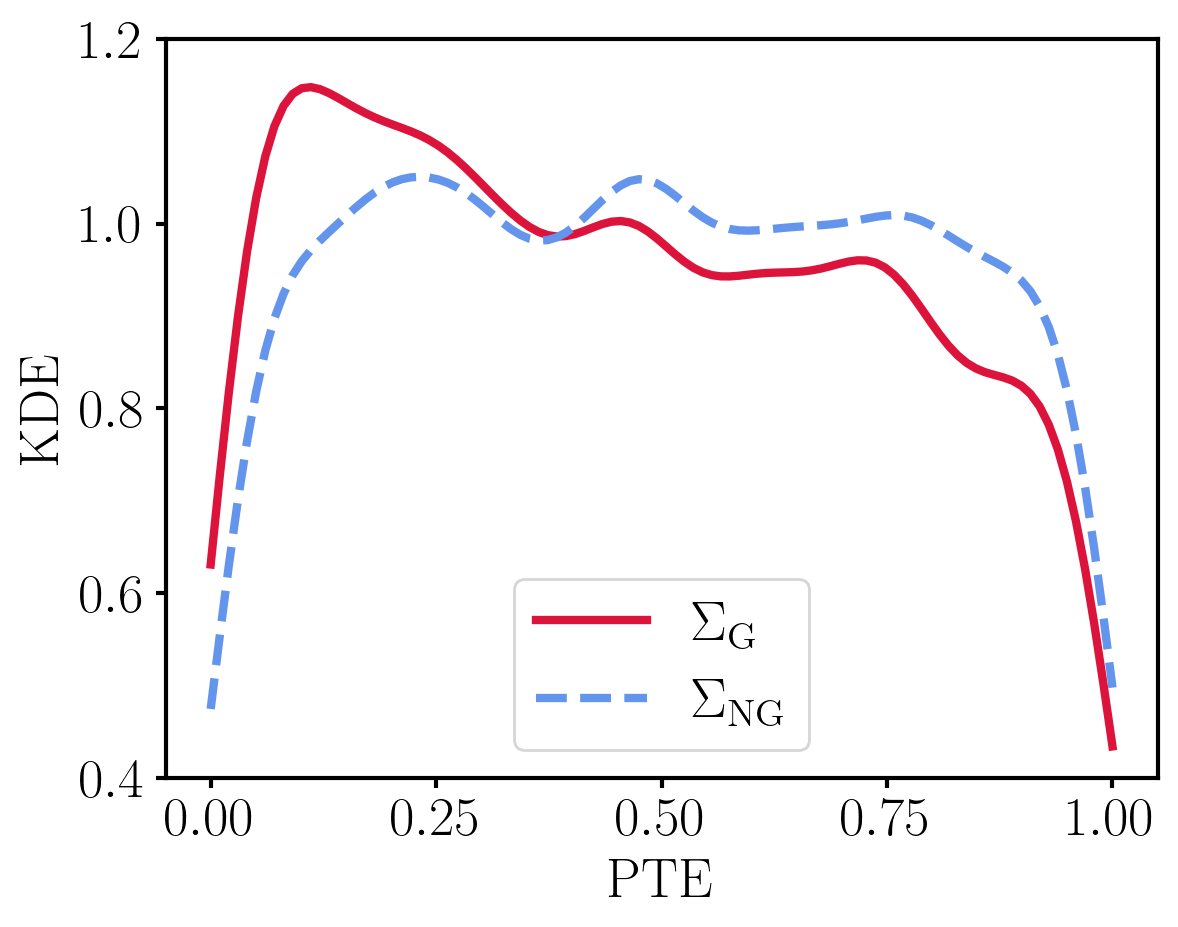

In [4]:
fig, axs = plt.subplots(dpi = 200)

pval_g = pd.read_csv(save_path + f'pval_array_g_{nsims}.txt', names = [r'$\Sigma_{\rm G}$'])
pval_g.plot.density(ind = np.linspace(0,1, num = 100), ax = axs, label = 'g', lw = 3, color = 'crimson')

pval_ng = pd.read_csv(save_path + f'pval_array_ng_{nsims}.txt', names = [r'$\Sigma_{\rm NG}$'])
pval_ng.plot.density(ind = np.linspace(0,1, num = 100), ax = axs, label = 'g', lw = 3, linestyle = 'dashed', color = 'cornflowerblue')


axs.set_ylabel(r'$\rm KDE$')
axs.set_ylim(0.4, 1.2)

axs.set_xlabel(r'$\rm PTE$')
axs.legend(prop = {'size':20})
    
# plt.savefig('/global/common/software/act/iabril/jupyter/Paper/Figures/cleanptes.pdf' , bbox_inches = 'tight')
plt.show()